In [1]:
import os, re, warnings, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")



In [2]:
# ---- Reproducibility ----
SEED = 42
random.seed(SEED); np.random.seed(SEED)



In [5]:
CSV_PATH = "/content/tweet_emotions.csv"
if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files  # type: ignore
        print("Upload your tweet_emotions.csv ...")
        uploaded = files.upload()
        # Take the first uploaded file if user changed the name
        CSV_PATH = list(uploaded.keys())[0]
    except Exception as e:
        raise FileNotFoundError("tweet_emotions.csv not found. Please upload it in Colab or place it in the working directory.") from e

df_raw = pd.read_csv(CSV_PATH)
print("Raw shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))



Raw shape: (40000, 3)
Columns: ['tweet_id', 'sentiment', 'content']


In [6]:
text_candidates = [c for c in df_raw.columns if c.lower() in {"text","tweet","content","message","sentence"}]
label_candidates = [c for c in df_raw.columns if c.lower() in {"label","emotion","sentiment","target","class","category"}]

if text_candidates:
    text_col = text_candidates[0]
else:
    # fallback: stringiest column
    string_cols = [c for c in df_raw.columns if df_raw[c].dtype == object]
    text_col = max(string_cols, key=lambda c: df_raw[c].astype(str).str.len().mean()) if string_cols else df_raw.columns[0]

if label_candidates:
    label_col = label_candidates[0]
else:
    non_text_cols = [c for c in df_raw.columns if c != text_col]
    label_col = min(non_text_cols, key=lambda c: df_raw[c].nunique()) if non_text_cols else df_raw.columns[-1]

df = (df_raw[[text_col, label_col]]
      .rename(columns={text_col: "text", label_col: "label"})
      .dropna(subset=["text","label"])
      .drop_duplicates(subset=["text","label"])
      .reset_index(drop=True))

print(f"Using columns: text='{text_col}' → 'text', label='{label_col}' → 'label'")
print("Unique labels:", df["label"].nunique())




Using columns: text='content' → 'text', label='sentiment' → 'label'
Unique labels: 13


In [7]:
# ---- Cleaning ----
url_pat = re.compile(r"https?://\S+|www\.\S+")
mention_pat = re.compile(r"@\w+")
hashtag_pat = re.compile(r"#([A-Za-z0-9_]+)")
html_pat = re.compile(r"&\w+;")
multi_space_pat = re.compile(r"\s+")

def clean_tweet(t: str) -> str:
    t = str(t).lower()
    t = url_pat.sub(" ", t)
    t = mention_pat.sub(" ", t)
    t = hashtag_pat.sub(r"\1", t)  # keep hashtag text
    t = html_pat.sub(" ", t)
    t = re.sub(r"[^\w\s]", " ", t, flags=re.UNICODE)  # strip most punctuation
    t = multi_space_pat.sub(" ", t).strip()
    return t

df["clean_text"] = df["text"].apply(clean_tweet)


In [8]:
# ---- Train/Valid split ----
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_all = le.fit_transform(df["label"])
class_names = list(le.classes_)

try:
    X_train, X_test, y_train, y_test = train_test_split(
        df["clean_text"], y_all, test_size=0.2, random_state=SEED, stratify=y_all
    )
except ValueError:
    # in case some classes are too small for stratify
    X_train, X_test, y_train, y_test = train_test_split(
        df["clean_text"], y_all, test_size=0.2, random_state=SEED
    )

print("Train:", X_train.shape[0], " Test:", X_test.shape[0], " Classes:", len(class_names))


Train: 31927  Test: 7982  Classes: 13



=== MultinomialNB ===
Accuracy: 0.2983 | Macro-F1: 0.0990 | Weighted-F1: 0.2233

Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.00      0.00      0.00       355
   happiness       0.38      0.15      0.21      1039
        hate       0.00      0.00      0.00       265
        love       0.57      0.16      0.25       760
     neutral       0.29      0.51      0.37      1724
      relief       0.00      0.00      0.00       305
     sadness       0.33      0.03      0.05      1032
    surprise       0.00      0.00      0.00       437
       worry       0.28      0.71      0.40      1690

    accuracy                           0.30      7982
   macro avg       0.14      0.12      0.10      7982
weighted avg       0.27     

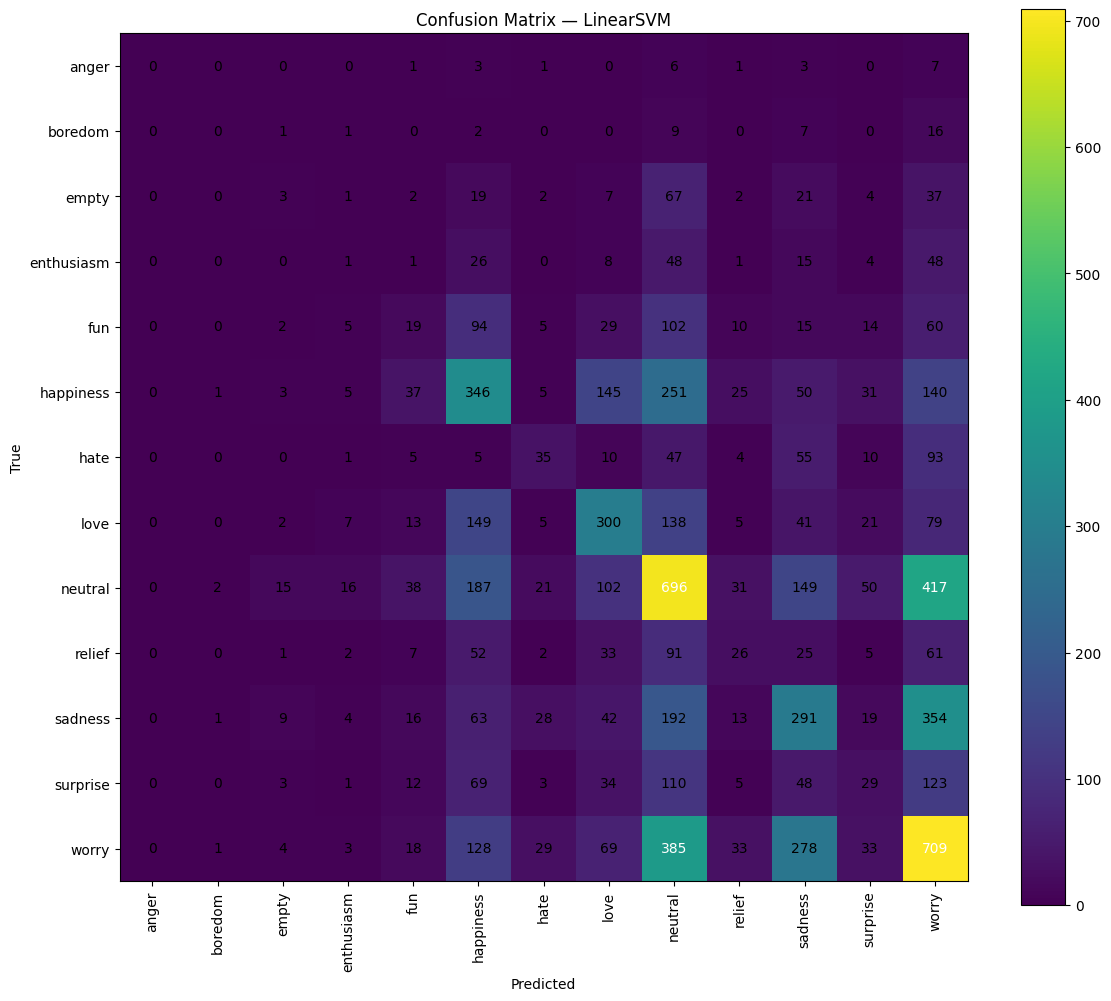

In [9]:
# =========================
# PART A — TF–IDF + Classic Models
# =========================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_features=50000,
    sublinear_tf=True
)

models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "LinearSVM": LinearSVC()
}

def evaluate_model(name, pipe, X_tr, y_tr, X_te, y_te, labels):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    acc = accuracy_score(y_te, pred)
    f1m = f1_score(y_te, pred, average="macro", zero_division=0)
    f1w = f1_score(y_te, pred, average="weighted", zero_division=0)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f} | Weighted-F1: {f1w:.4f}")
    print("\nClassification Report:\n", classification_report(y_te, pred, target_names=labels, zero_division=0))
    return {"Model": name, "Accuracy": acc, "F1_macro": f1m, "F1_weighted": f1w, "y_pred": pred}

results = []
for name, clf in models.items():
    pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
    res = evaluate_model(name, pipe, X_train, y_train, X_test, y_test, class_names)
    results.append({k:v for k,v in res.items() if k!="y_pred"})
    if name == "LinearSVM":
        cm = confusion_matrix(y_test, res["y_pred"], labels=range(len(class_names)))
        plt.figure(figsize=(min(12, 0.6*len(class_names)+4), min(10, 0.6*len(class_names)+4)))
        plt.imshow(cm, interpolation='nearest')
        plt.title("Confusion Matrix — LinearSVM")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        thresh = cm.max() / 2 if cm.max() > 0 else 1
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, int(cm[i, j]),
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()



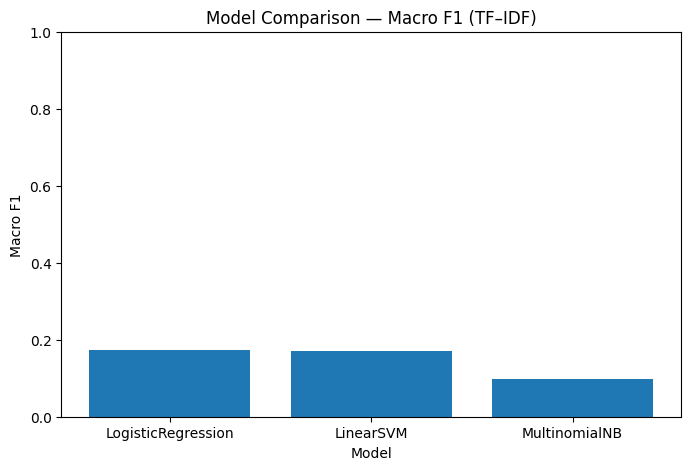

In [10]:
# Model comparison bar chart
pd_results = pd.DataFrame(results).sort_values("F1_macro", ascending=False)
plt.figure(figsize=(8,5))
plt.bar(pd_results["Model"], pd_results["F1_macro"])
plt.title("Model Comparison — Macro F1 (TF–IDF)")
plt.xlabel("Model"); plt.ylabel("Macro F1")
plt.ylim(0, 1)
plt.show()



In [11]:
# =========================
# PART B — Deep Learning (BiLSTM on token indices)
# =========================
print("\n\n=== BiLSTM on token indices (Keras) ===")
import tensorflow as tf
tf.random.set_seed(SEED)

# Tokenization with Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 30000
MAX_LEN = 64

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train.tolist())
Xtr_seq = tokenizer.texts_to_sequences(X_train.tolist())
Xte_seq = tokenizer.texts_to_sequences(X_test.tolist())

Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding="post", truncating="post")
Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding="post", truncating="post")





=== BiLSTM on token indices (Keras) ===


In [13]:
num_classes = len(class_names)

from tensorflow.keras import layers, models, callbacks

def build_bilstm_model(vocab_size, max_len, num_classes, embed_dim=128, lstm_units=64, dropout=0.2):
    inp = layers.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(vocab_size, embed_dim, input_length=max_len)(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_bilstm_model(VOCAB_SIZE, MAX_LEN, num_classes)
model.summary()

# Class weights to help with imbalance
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight="balanced", classes=np.arange(num_classes), y=y_train)
class_weights = {i: w for i, w in enumerate(cw)}

es = callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
hist = model.fit(Xtr_pad, y_train,
    validation_split=0.1,
    epochs=8,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 64, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,940,493 (15.03 MB)

 Trainable params: 3,940,493 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.0868 - loss: 2.5493 - val_accuracy: 0.1776 - val_loss: 2.3734
Epoch 2/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2275 - loss: 2.2359 - val_accuracy: 0.1694 - val_loss: 2.3791
Epoch 3/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3313 - loss: 1.7387 - val_accuracy: 0.1845 - val_loss: 2.5018
Epoch 4/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4720 - loss: 1.2311 - val_accuracy: 0.1898 - val_loss: 2.6703
Epoch 5/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5772 - loss: 0.9384 - val_accuracy: 0.2095 - val_loss: 2.7275
Epoch 6/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6675 - loss: 0.7073 - val_accuracy: 0.2161 - val_loss: 2.8371
Epoch 7/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7174 - loss: 0.5830 - val_accuracy: 0.1995 - val_loss: 3.0220
Epoch 8/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7563 - loss: 0.4845 - val_accuracy: 0.

BiLSTM — Accuracy: 0.2256 | Macro-F1: 0.1686 | Weighted-F1: 0.2406

Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.05      0.17      0.07        36
       empty       0.03      0.13      0.05       165
  enthusiasm       0.04      0.12      0.06       152
         fun       0.10      0.17      0.12       355
   happiness       0.26      0.28      0.27      1039
        hate       0.21      0.31      0.25       265
        love       0.36      0.32      0.34       760
     neutral       0.37      0.20      0.26      1724
      relief       0.10      0.14      0.12       305
     sadness       0.25      0.30      0.27      1032
    surprise       0.12      0.12      0.12       437
       worry       0.37      0.19      0.25      1690

    accuracy                           0.23      7982
   macro avg       0.17      0.19      0.17      7982
weighted avg       0.28      0.23      0.2

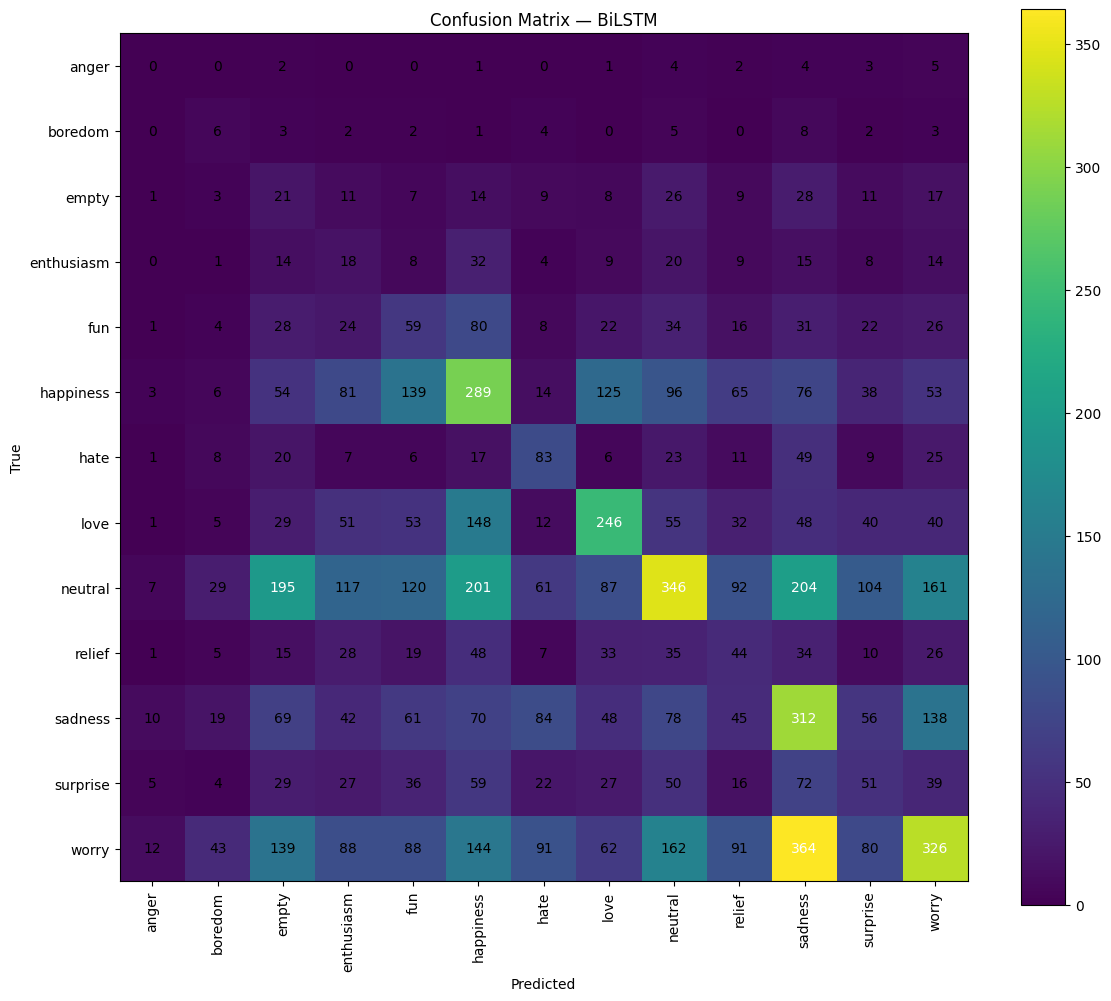

In [14]:
# Evaluate
probs = model.predict(Xte_pad, batch_size=256, verbose=0)
y_pred_bilstm = probs.argmax(axis=1)
acc_bi = accuracy_score(y_test, y_pred_bilstm)
f1m_bi = f1_score(y_test, y_pred_bilstm, average="macro", zero_division=0)
f1w_bi = f1_score(y_test, y_pred_bilstm, average="weighted", zero_division=0)
print(f"BiLSTM — Accuracy: {acc_bi:.4f} | Macro-F1: {f1m_bi:.4f} | Weighted-F1: {f1w_bi:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bilstm, target_names=class_names, zero_division=0))

# Optional confusion matrix for BiLSTM
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm, labels=range(num_classes))
plt.figure(figsize=(min(12, 0.6*len(class_names)+4), min(10, 0.6*len(class_names)+4)))
plt.imshow(cm_bilstm, interpolation='nearest')
plt.title("Confusion Matrix — BiLSTM")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
thresh = cm_bilstm.max() / 2 if cm_bilstm.max() > 0 else 1
for i in range(cm_bilstm.shape[0]):
    for j in range(cm_bilstm.shape[1]):
        plt.text(j, i, int(cm_bilstm[i, j]),
                 ha="center", va="center",
                 color="white" if cm_bilstm[i, j] > thresh else "black")
plt.tight_layout()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [18]:
# =========================
# PART C — (Optional) DistilBERT fine-tuning
# =========================
USE_BERT = False  # <<< set True to run
if USE_BERT:
    # Installs for Colab
    import sys
    if "google.colab" in sys.modules:
        !pip -q install -U transformers datasets accelerate

    from datasets import Dataset, ClassLabel
    from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
    import evaluate

    model_name = "distilbert-base-uncased"
    tokenizer_hf = AutoTokenizer.from_pretrained(model_name)

    # Build HF datasets from cleaned text
    df_train = pd.DataFrame({"text": X_train.values, "label": y_train})
    df_test  = pd.DataFrame({"text": X_test.values,  "label": y_test})

    # Make sure labels start at 0..num_classes-1
    unique_sorted = sorted(np.unique(np.concatenate([df_train["label"].values, df_test["label"].values])))
    id2label = {i: class_names[i] for i in unique_sorted}
    label2id = {v:k for k,v in id2label.items()}

    def tokenize_fn(batch):
        return tokenizer_hf(batch["text"], truncation=True, max_length=96)

    ds_train = Dataset.from_pandas(df_train)
    ds_test  = Dataset.from_pandas(df_test)
    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds_test  = ds_test.map(tokenize_fn, batched=True, remove_columns=["text"])

    collator = DataCollatorWithPadding(tokenizer_hf)

    model_hf = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_classes, id2label=id2label, label2id=label2id
    )

    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
        }

    args = TrainingArguments(
        output_dir="./bert-emotion",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        load_best_model_at_end=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model_hf,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        tokenizer=tokenizer_hf,
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_metrics = trainer.evaluate()
    print("\nDistilBERT Eval:",eval_metrics)

In [19]:
# === DistilBERT fine-tuning (clean, verbose, Colab-safe) ===
USE_BERT = True  # make sure this is True

import sys, subprocess, os, numpy as np, pandas as pd

def pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs
    print("Installing:", " ".join(pkgs))
    subprocess.check_call(cmd)

if USE_BERT:
    # 1) Install deps (quiet-ish)
    try:
        import transformers, datasets, accelerate, evaluate  # noqa
        print("Transformers stack already present.")
    except Exception:
        pip_install(["transformers>=4.40", "datasets>=2.19", "accelerate>=0.30", "evaluate>=0.4.1"])
        import transformers, datasets, accelerate, evaluate  # noqa

    from datasets import Dataset
    from transformers import (
        AutoTokenizer, DataCollatorWithPadding,
        AutoModelForSequenceClassification,
        TrainingArguments, Trainer
    )

    print("Preparing DistilBERT data…")

    # Build HF datasets from your existing splits (X_train/X_test etc.)
    df_train = pd.DataFrame({"text": X_train.values, "label": y_train})
    df_test  = pd.DataFrame({"text": X_test.values,  "label": y_test})

    model_name = "distilbert-base-uncased"
    tokenizer_hf = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer_hf(batch["text"], truncation=True, max_length=96)

    ds_train = Dataset.from_pandas(df_train)
    ds_test  = Dataset.from_pandas(df_test)
    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text", "_index_level_0_"])
    ds_test  = ds_test.map(tokenize_fn, batched=True, remove_columns=["text", "_index_level_0_"])

    collator = DataCollatorWithPadding(tokenizer_hf)

    id2label = {i: cls for i, cls in enumerate(class_names)}
    label2id = {v: k for k, v in id2label.items()}
    num_classes = len(class_names)

    print("Loading model…")
    model_hf = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_classes, id2label=id2label, label2id=label2id
    )

    # Metrics
    import evaluate as hf_evaluate
    metric_acc = hf_evaluate.load("accuracy")
    metric_f1 = hf_evaluate.load("f1")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
        }

    print("Configuring Trainer…")
    args = TrainingArguments(
        output_dir="./bert-emotion",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,          # keep small for quick run
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model_hf,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        tokenizer=tokenizer_hf,
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    print("Starting training…")
    train_output = trainer.train()
    print("Training complete.")
    print("Train summary:", train_output)

    print("Evaluating…")
    eval_metrics = trainer.evaluate()
    print("\nDistilBERT Eval:", eval_metrics)
else:
    print("BERT block skipped (USE_BERT=False).")

Installing: transformers>=4.40 datasets>=2.19 accelerate>=0.30 evaluate>=0.4.1
Preparing DistilBERT data…


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

ValueError: Column to remove ['_index_level_0_'] not in the dataset. Current columns in the dataset: ['text', 'label']

In [20]:
# === DistilBERT fine-tuning (updated, robust, Colab-friendly) ===
# Paste this AFTER you have X_train, X_test, y_train, y_test, and class_names defined.
# It installs deps if missing, builds HF datasets WITHOUT index columns,
# tokenizes, trains, and evaluates with accuracy + macro-F1.

USE_BERT = True  # set False to skip

import sys, subprocess, numpy as np, pandas as pd

def pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs
    print("Installing:", " ".join(pkgs))
    subprocess.check_call(cmd)

if USE_BERT:
    # Ensure deps
    try:
        import transformers, datasets, accelerate, evaluate  # noqa: F401
        print("Transformers stack already present.")
    except Exception:
        pip_install(["transformers>=4.40", "datasets>=2.19", "accelerate>=0.30", "evaluate>=0.4.1"])
        import transformers, datasets, accelerate, evaluate  # noqa: F401

    from datasets import Dataset
    from transformers import (
        AutoTokenizer, DataCollatorWithPadding,
        AutoModelForSequenceClassification,
        TrainingArguments, Trainer
    )

    # Build DataFrames from your existing splits
    df_train = pd.DataFrame({"text": X_train.values, "label": y_train})
    df_test  = pd.DataFrame({"text": X_test.values,  "label": y_test})

    model_name = "distilbert-base-uncased"
    tokenizer_hf = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer_hf(batch["text"], truncation=True, max_length=96)

    # IMPORTANT: don't preserve the pandas index (avoids index column removal issues)
    ds_train = Dataset.from_pandas(df_train, preserve_index=False)
    ds_test  = Dataset.from_pandas(df_test,  preserve_index=False)

    # Tokenize; only remove the 'text' column
    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"], load_from_cache_file=False)
    ds_test  = ds_test.map(tokenize_fn,  batched=True, remove_columns=["text"], load_from_cache_file=False)

    num_classes = len(class_names)
    id2label = {i: cls for i, cls in enumerate(class_names)}
    label2id = {v: k for k, v in id2label.items()}

    print("Loading model…")
    model_hf = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_classes, id2label=id2label, label2id=label2id
    )

    # Metrics
    import evaluate as hf_evaluate
    metric_acc = hf_evaluate.load("accuracy")
    metric_f1 = hf_evaluate.load("f1")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
        }

    print("Configuring Trainer…")
    args = TrainingArguments(
        output_dir="./bert-emotion",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,          # keep small for a quick run
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model_hf,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        tokenizer=tokenizer_hf,
        data_collator=DataCollatorWithPadding(tokenizer_hf),
        compute_metrics=compute_metrics
    )

    print("Starting training…")
    train_output = trainer.train()
    print("Training complete.")
    print("Train summary:", train_output)

    print("Evaluating…")
    eval_metrics = trainer.evaluate()
    print("\nDistilBERT Eval:", eval_metrics)
else:
    print("BERT block skipped (USE_BERT=False).")

Transformers stack already present.


Map:   0%|          | 0/31927 [00:00<?, ? examples/s]

Map:   0%|          | 0/7982 [00:00<?, ? examples/s]

Loading model…


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configuring Trainer…


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [25]:
# === DistilBERT fine-tuning (fixed & version-adaptive) ===
# Run AFTER you have: X_train, X_test, y_train, y_test, class_names
USE_BERT = True

import sys, subprocess, inspect, numpy as np, pandas as pd

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

if USE_BERT:
    # Ensure deps
    try:
        import transformers, datasets, accelerate, evaluate  # noqa: F401
        from transformers import TrainingArguments  # test import
    except Exception:
        pip_install(["transformers>=4.40", "datasets>=2.19", "accelerate>=0.30", "evaluate>=0.4.1"])
        import transformers, datasets, accelerate, evaluate  # noqa: F401
        from transformers import TrainingArguments

    from datasets import Dataset
    from transformers import (
        AutoTokenizer, DataCollatorWithPadding,
        AutoModelForSequenceClassification,
        Trainer
    )

    # print("Transformers version:", transformers._version_)

    # Build DataFrames from existing splits
    df_train = pd.DataFrame({"text": X_train.values, "label": y_train})
    df_test  = pd.DataFrame({"text": X_test.values,  "label": y_test})

    model_name = "distilbert-base-uncased"
    tokenizer_hf = AutoTokenizer.from_pretrained(model_name)

    def tokenize_fn(batch):
        return tokenizer_hf(batch["text"], truncation=True, max_length=96)

    # No index column preserved (avoids _index_level_0_ removal headaches)
    ds_train = Dataset.from_pandas(df_train, preserve_index=False)
    ds_test  = Dataset.from_pandas(df_test,  preserve_index=False)

    ds_train = ds_train.map(tokenize_fn, batched=True, remove_columns=["text"], load_from_cache_file=False)
    ds_test  = ds_test.map(tokenize_fn,  batched=True, remove_columns=["text"], load_from_cache_file=False)

    num_classes = len(class_names)
    id2label = {i: cls for i, cls in enumerate(class_names)}
    label2id = {v: k for k, v in id2label.items()}

    print("Loading model…")
    model_hf = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_classes, id2label=id2label, label2id=label2id
    )

    # Metrics
    import evaluate as hf_evaluate
    metric_acc = hf_evaluate.load("accuracy")
    metric_f1 = hf_evaluate.load("f1")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
        }

    # ---- Version-adaptive TrainingArguments (correct _init_) ----
    try:
        sig = inspect.signature(TrainingArguments._init_)
        supported = set(sig.parameters.keys())
    except Exception:
        supported = set()  # extremely old versions fallback

    args_kwargs = {
        "output_dir": "./bert-emotion",
        "learning_rate": 2e-5,
        "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 32,
        "num_train_epochs": 2,      # quick run
        "weight_decay": 0.01,
        "logging_steps": 50,
    }
    if "evaluation_strategy" in supported:
        args_kwargs["evaluation_strategy"] = "epoch"
    if "save_strategy" in supported:
        args_kwargs["save_strategy"] = "no"
    if "report_to" in supported:
        args_kwargs["report_to"] = "none"
    if "lr_scheduler_type" in supported:
        args_kwargs["lr_scheduler_type"] = "linear"

    print("Configuring Trainer with args:", args_kwargs)
    args = TrainingArguments(**args_kwargs)

    trainer = Trainer(
        model=model_hf,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_test,
        tokenizer=tokenizer_hf,
        data_collator=DataCollatorWithPadding(tokenizer_hf),
        compute_metrics=compute_metrics
    )

    print("Starting training…")
    train_output = trainer.train()
    print("Training complete.")
    print("Train summary:", train_output)

    print("Evaluating…")
    eval_metrics = trainer.evaluate()
    print("\nDistilBERT Eval:", eval_metrics)
else:
    print("BERT block skipped (USE_BERT=False).")

Map:   0%|          | 0/31927 [00:00<?, ? examples/s]

Map:   0%|          | 0/7982 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model…
Configuring Trainer with args: {'output_dir': './bert-emotion', 'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 32, 'num_train_epochs': 2, 'weight_decay': 0.01, 'logging_steps': 50}
Starting training…


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mableaugustus (mableaugustus-tkm-college-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,2.344600
100,2.158700
150,2.051500
200,1.967900
250,2.008500
300,1.963900
350,1.951800
400,1.874100
450,1.925100
500,1.891400


Training complete.
Train summary: TrainOutput(global_step=3992, training_loss=1.7947151474580019, metrics={'train_runtime': 461.6251, 'train_samples_per_second': 138.324, 'train_steps_per_second': 8.648, 'total_flos': 514969180550556.0, 'train_loss': 1.7947151474580019, 'epoch': 2.0})
Evaluating…



DistilBERT Eval: {'eval_loss': 1.7762194871902466, 'eval_accuracy': 0.38950137810072666, 'eval_f1_macro': 0.20332264150827864, 'eval_runtime': 7.9831, 'eval_samples_per_second': 999.867, 'eval_steps_per_second': 31.316, 'epoch': 2.0}



=== MultinomialNB ===
Accuracy: 0.2983 | Macro-F1: 0.0990 | Weighted-F1: 0.2233
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.00      0.00      0.00       355
   happiness       0.38      0.15      0.21      1039
        hate       0.00      0.00      0.00       265
        love       0.57      0.16      0.25       760
     neutral       0.29      0.51      0.37      1724
      relief       0.00      0.00      0.00       305
     sadness       0.33      0.03      0.05      1032
    surprise       0.00      0.00      0.00       437
       worry       0.28      0.71      0.40      1690

    accuracy                           0.30      7982
   macro avg       0.14      0.12      0.10      7982
weighted avg       0.27      0.30      0.22      7982


=== DistilBERT ===
Accuracy: 0.3895 | Macro-F1: 0.2033 | Weighted-F1: 0.3532
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        36
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.29      0.02      0.04       355
   happiness       0.34      0.53      0.41      1039
        hate       0.36      0.35      0.35       265
        love       0.49      0.43      0.46       760
     neutral       0.41      0.54      0.47      1724
      relief       0.36      0.05      0.09       305
     sadness       0.38      0.26      0.31      1032
    surprise       0.35      0.04      0.07       437
       worry       0.39      0.53      0.44      1690

    accuracy                           0.39      7982
   macro avg       0.26      0.21      0.20      7982
weighted avg       0.37      0.39      0.35      7982




,Model,Accuracy,F1_macro,F1_weighted
0,DistilBERT,0.389501,0.203323,0.353239
1,LogisticRegression,0.354924,0.173029,0.316887
2,LinearSVM,0.307567,0.170052,0.290496
3,BiLSTM,0.225633,0.168625,0.240567
4,MultinomialNB,0.298296,0.098967,0.223278



Saved: all_models_comparison.csv


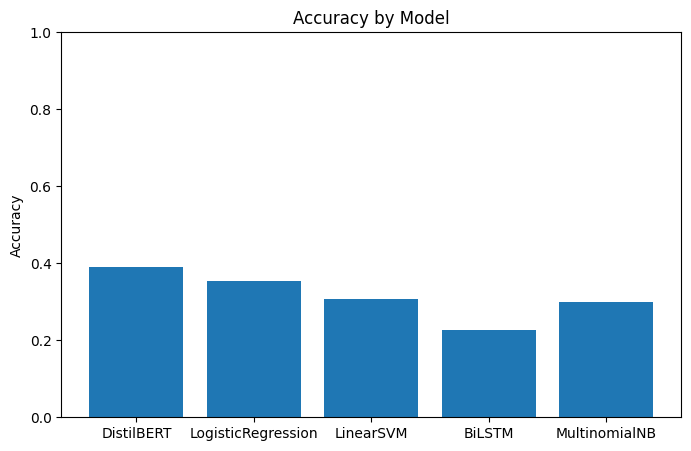

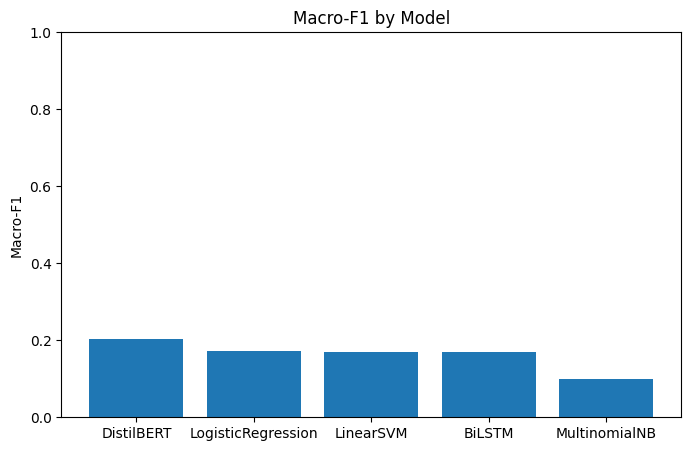

<Figure size 1180x1000 with 0 Axes>

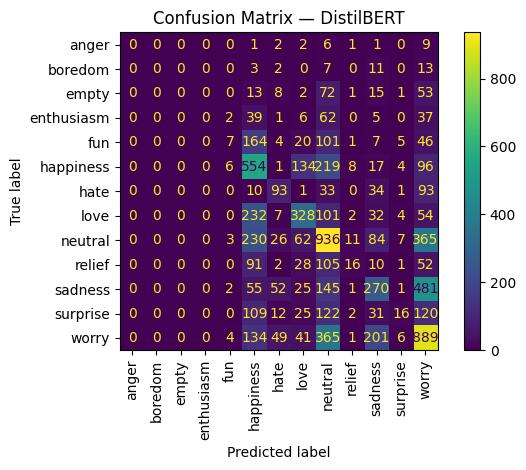

In [26]:
# =========================
# Unified model comparison (classic + BiLSTM + BERT if available)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

SEED = 42

def summarize(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "F1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }

results = []
reports = {}

# ---------- A) Classic models (TF–IDF) ----------
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000, sublinear_tf=True)

classic_models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=SEED),
    "LinearSVM": LinearSVC()
}

for name, clf in classic_models.items():
    pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    met = summarize(y_test, y_pred)
    results.append({"Model": name, **met})
    reports[name] = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {met['Accuracy']:.4f} | Macro-F1: {met['F1_macro']:.4f} | Weighted-F1: {met['F1_weighted']:.4f}")
    print(reports[name])

# ---------- B) BiLSTM (optional, if present) ----------
# Expecting: model (Keras) and Xte_pad (padded test sequences) in memory
try:
    _ = model  # will raise NameError if not present
    _ = Xte_pad
    probs = model.predict(Xte_pad, batch_size=256, verbose=0)
    y_pred_bilstm = probs.argmax(axis=1)
    met_bi = summarize(y_test, y_pred_bilstm)
    results.append({"Model": "BiLSTM", **met_bi})
    reports["BiLSTM"] = classification_report(y_test, y_pred_bilstm, target_names=class_names, zero_division=0)
    print(f"\n=== BiLSTM ===")
    print(f"Accuracy: {met_bi['Accuracy']:.4f} | Macro-F1: {met_bi['F1_macro']:.4f} | Weighted-F1: {met_bi['F1_weighted']:.4f}")
    print(reports["BiLSTM"])
except NameError:
    print("\n[Info] BiLSTM objects not found (model/Xte_pad). Skipping BiLSTM in the comparison.")
except Exception as e:
    print("\n[Info] BiLSTM present but evaluation failed:", e)

# ---------- C) DistilBERT (optional, if present) ----------
# Expecting: trainer and ds_test in memory from the HF block
try:
    _ = trainer
    _ = ds_test
    pred_out = trainer.predict(ds_test)
    y_pred_bert = np.argmax(pred_out.predictions, axis=-1)
    met_bert = summarize(pred_out.label_ids, y_pred_bert)
    results.append({"Model": "DistilBERT", **met_bert})
    reports["DistilBERT"] = classification_report(pred_out.label_ids, y_pred_bert, target_names=class_names, zero_division=0)
    print(f"\n=== DistilBERT ===")
    print(f"Accuracy: {met_bert['Accuracy']:.4f} | Macro-F1: {met_bert['F1_macro']:.4f} | Weighted-F1: {met_bert['F1_weighted']:.4f}")
    print(reports["DistilBERT"])
except NameError:
    print("\n[Info] HuggingFace trainer/ds_test not found. Skipping DistilBERT in the comparison.")
except Exception as e:
    print("\n[Info] DistilBERT present but evaluation failed:", e)

# ---------- Summary table ----------
summary_df = pd.DataFrame(results).sort_values("F1_macro", ascending=False).reset_index(drop=True)
print("\n====== Summary (sorted by Macro-F1) ======")
display(summary_df)

# Save to CSV for your report
summary_df.to_csv("all_models_comparison.csv", index=False)
print("\nSaved: all_models_comparison.csv")

# ---------- Plots ----------
plt.figure(figsize=(8,5))
plt.bar(summary_df["Model"], summary_df["Accuracy"])
plt.title("Accuracy by Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(summary_df["Model"], summary_df["F1_macro"])
plt.title("Macro-F1 by Model")
plt.ylabel("Macro-F1")
plt.ylim(0, 1)
plt.show()

# (Optional) show confusion matrix for the current top model
top_model_name = summary_df.loc[0, "Model"]
if top_model_name in ["MultinomialNB", "LogisticRegression", "LinearSVM"]:
    # Refit to get its predictions again for CM
    clf = classic_models[top_model_name]
    pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
elif top_model_name == "BiLSTM":
    y_pred = y_pred_bilstm
elif top_model_name == "DistilBERT":
    y_pred = y_pred_bert
else:
    y_pred = None

if y_pred is not None:
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(min(12, 0.6*len(class_names)+4), min(10, 0.6*len(class_names)+4)))
    disp.plot(include_values=True, xticks_rotation=90)
    plt.title(f"Confusion Matrix — {top_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("[Info] Could not compute confusion matrix for the top model.")